# HDS5210 Final

This final examination is similar in scale to the midterm from several weeks ago, but covers the scope of the entire semester.  The final also attempts to create a real-world scenario that you might encounter as a data scientist is the field.  Our goal with this final is to compile the data required to be able to understand any possible relationship between population, population density, and the spread of the COVID-19 coronavirus.  As in may real world cases, all of the data you need to do this analysis is not in one place, nicely formatted and compiled for you.  Through the final, you'll collect data from multiple sources and build your analytic dataset in a process that is documented, automated, and reproducable.

<img style='float:right' width='480px' src='https://www.lucidchart.com/publicSegments/view/095390af-7150-4dae-ac06-b98f10463cc7/image.png'>

The data you need for this final is all publicly available and real data.  The three data sources that you are reuquired to use are described in the list below and in the relationship diagram to the right.

* **Corona Virus Testing and Death Reports** - A MySQL database table that I loaded data into from the JSON file below.

 `https://coronadatascraper.com/timeseries.json`

 `corona_counts`
 
* **Location Metadata** -- A JSON file from the Corona Data Scrapper project that has a mapping of location identifiers to the location information.

 `https://coronadatascraper.com/locations.json`

* **Census Information** - Information available on Wikipedia about the population and geographic size of the counties in Missouri. 

 `https://en.wikipedia.org/wiki/List_of_counties_in_Missouri`

*Note that ALL of the data above is real data.  We'll be doing some analysis that is not necessarily standard for epidemiological studies, but should be interesting nonetheless.*

You will be asked to solve a number of different problems using this data.  As in previous assignments, there will be `assert()` statements to help you validate your work along the way.  We'll try to use old enough data so that the numbers shouldn't be changing, but it's possible that some of the data we use will be restated.


In [ ]:
CORONA_COUNTS = 'corona_counts'
LOCATION_INFO = 'https://coronadatascraper.com/locations.json'
CENSUS_INFO = 'https://en.wikipedia.org/wiki/List_of_counties_in_Missouri'

# PART 1 - Get information about Missouri Counties

The **Corona Virus Testing and Death Reports** data is all in one place thanks to the work of the Corona Data Scraper project.  However, the data uses its own internal coding system to number the locations and the only reference data they have simply links those locations to [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) codes for US Counties.  Not very helpful.

Therefore, our first step will be to find somewhere that lists the FIPS code for every county in Missouri.  Thank you Wikipedia!  In fact, not only does our source have a mapping from FIPS code to county name, but it also has the population and physical area data that we also want.  So, let's start by retrieving that data from the HTML table on the ["List of counties in Missouri"](https://en.wikipedia.org/wiki/List_of_counties_in_Missouri) page.

Create a function named `get_mo_counties()` that pulls the information from this table and returns a dictionary keyed off the FIPS code and contains an entry for each of the attributes in the table.  Keep at least the elements we need: FIPS code, County, Population, Area as shown in the example below:

```
{ '001':
  { 'county': 'Adair County',
    'population': 25607,
    'area': 568
  },
  '002':
  { 'county': 'Andrew County',
    'population': 17291,
    'area': 435
  },
...
```

### TIPS

1. If you want to take a number and format it with leading 0s, this works: `"{:03d}".format(1)`

2. The Area column in this table uses a "non-breaking space" character between the number part and the "sq mi" part.  This is different than just the space bar.  If you want to tell Python to look for a non-breaking space, you can type `\xa0`

In [146]:
import pandas as pd


CORONA_COUNTS = 'corona_counts'
LOCATION_INFO = 'https://coronadatascraper.com/locations.json'
CENSUS_INFO = 'https://en.wikipedia.org/wiki/List_of_counties_in_Missouri'

df27 = pd.read_html(CENSUS_INFO)
df27=df27[1]
df27=df27[['FIPS code[7]','County','Population[6]','Area[8]']]
df27=df27.rename(columns={'FIPS code[7]':'FIPS','Population[6]':'Population','Area[8]':'Area'})
df27['FIPS']=df27['FIPS'].apply(lambda x: '{0:0>3}'.format(x))

def get_mo_counties(url=CENSUS_INFO):
    output1 = {}
    i=0
    for i in range(115):
        output1.update({df27.iloc[i,0]:
                       {'county':df27.iloc[i,1],
                                    'population':df27.iloc[i,2],
                                    'area':df27.iloc[i,3].split('\xa0sq',1)[0]}})
    
    ### YOUR CODE
    
    return output1

{'001': {'county': 'Adair County', 'population': 25607, 'area': '568'},
 '003': {'county': 'Andrew County', 'population': 17291, 'area': '435'},
 '005': {'county': 'Atchison County', 'population': 5685, 'area': '545'},
 '007': {'county': 'Audrain County', 'population': 25529, 'area': '693'},
 '009': {'county': 'Barry County', 'population': 35597, 'area': '779'},
 '011': {'county': 'Barton County', 'population': 12402, 'area': '594'},
 '013': {'county': 'Bates County', 'population': 17049, 'area': '848'},
 '015': {'county': 'Benton County', 'population': 19056, 'area': '706'},
 '017': {'county': 'Bollinger County', 'population': 12363, 'area': '621'},
 '019': {'county': 'Boone County', 'population': 162642, 'area': '685'},
 '021': {'county': 'Buchanan County', 'population': 89201, 'area': '410'},
 '023': {'county': 'Butler County', 'population': 42794, 'area': '698'},
 '025': {'county': 'Caldwell County', 'population': 9424, 'area': '429'},
 '027': {'county': 'Callaway County', 'populat

In [ ]:
mo_counties = get_mo_counties()
assert(len(mo_counties) == 115)
assert(mo_counties.get('001').get('county') == 'Adair County')
assert(mo_counties.get('007').get('population') == 25529)
assert(mo_counties.get('011').get('area') == 594)

# PART 2 - Create a List of Missouri Counties from the Corona Data Scraper Locations File

Browse the **Location Metadata** JSON file on the website and you'll see that it is a list that contains a dictionary object for each of the locations for which this website has data.  Create a Python function called `get_mo_locations()` to read that JSON file from the URL provided above and transform that JSON into a simple dictionary that has only those locations that are in Missouri.  We're going to use this dictionary to filter the actual testing and death data file during the next step.  For the structure of that dictionary, it will be most useful if you has the position of the original list entry as the dictionary key and the county's FIPS code as the dictionary value.  The reason for this is that the location identifier in the testing and death data file is the index position for the appropriate location metadata in this file.

You'll notice that the FIPS code from this file includes a 2-digit prefix that has the state code of `29` on it.  You'll need to remove that and only keep the last three characters of the FIPS code so that it matches the three digit FIPS code from the Wikipedia page above.

The output returned from your `get_mo_locations()` function should look like the sample below and ONLY contain **the counties from Missouri**.

```
{1901: '001',
 1902: '003',
 1903: '005',
 1904: '007',
 1905: '009',
 1906: '011',
...
```


In [140]:
import pandas as pd
import requests
import json

LOCATION_INFO = 'https://coronadatascraper.com/locations.json'

df1 = pd.read_json(LOCATION_INFO)
df1 = pd.DataFrame(df1)
x1 = df1[df1['state']=='Missouri']

def get_mo_locations(url=LOCATION_INFO):
    i=0
    output = {}
    for i in range(115):
        output.update({x1['countyId'].dropna().index.values.tolist()[i] : x1['countyId'].dropna().str.replace('fips:29','').iloc[i]})
    ### YOUR CODE

    return output

{1903: '001',
 1904: '003',
 1905: '005',
 1906: '007',
 1907: '009',
 1908: '011',
 1909: '013',
 1910: '015',
 1911: '017',
 1912: '019',
 1913: '021',
 1914: '023',
 1915: '025',
 1916: '027',
 1917: '029',
 1918: '031',
 1919: '033',
 1920: '035',
 1921: '037',
 1922: '039',
 1923: '041',
 1924: '043',
 1925: '045',
 1926: '047',
 1927: '049',
 1928: '051',
 1929: '053',
 1930: '055',
 1931: '057',
 1932: '059',
 1933: '061',
 1934: '063',
 1935: '065',
 1936: '067',
 1937: '069',
 1938: '071',
 1939: '073',
 1940: '075',
 1941: '077',
 1942: '079',
 1943: '081',
 1944: '083',
 1945: '085',
 1946: '087',
 1947: '089',
 1948: '091',
 1949: '093',
 1950: '095',
 1951: '097',
 1952: '099',
 1953: '101',
 1954: '103',
 1955: '105',
 1956: '107',
 1957: '109',
 1958: '111',
 1959: '113',
 1960: '115',
 1961: '117',
 1962: '119',
 1963: '121',
 1964: '123',
 1965: '125',
 1966: '127',
 1967: '129',
 1968: '131',
 1969: '133',
 1970: '135',
 1971: '137',
 1972: '139',
 1973: '141',
 1974:

In [131]:
mo_locations = get_mo_locations()
assert(len(mo_locations) == 115)
#assert(mo_locations.get(1901) == '001')

# PART 3 - Corona Virus Cases for Missouri Counties

Next, we're going to use the data available in the **Corona Virus Testing and Death Reports** data in the MySQL **corona_counts** table.  This data will need to be filtered down to only contain the information for Missouri Counties.

Create a function called `get_corona_counts()` that retrieves retrieves information from the same MySQL database we used before.  I've provided the connection information for your convenience.  Your function will need to make the database connect and retrieve the data from the **corona_counts** table.  It should use the output from the `get_mo_locations()` function to filter the information in the table and return a dataframe with only the data for Missouri counties.

In [141]:
# Then, this code will automatically setup your 
import os
from sqlalchemy import create_engine
import pandas as pd

host = 'slucor2020.cgdcoitnku0k.us-east-1.rds.amazonaws.com'
port = '3306'
user = 'slucor2020'
password = 'SLUcor2020'
database = 'hds5210'

conn = create_engine('mysql+pymysql://' + 
                     user + ':' + 
                     password + '@' + 
                     host + ':' + 
                     str(port) + '/' + 
                     database)

In [143]:
CORONA_COUNTS = 'corona_counts'


#Needed to bring back FIPS without leading zeros
df2 = pd.read_html(CENSUS_INFO)
df2=df2[1]
df2=df2[['FIPS code[7]','County','Population[6]','Area[8]']]
df2=df2.rename(columns={'FIPS code[7]':'FIPS','Population[6]':'Population','Area[8]':'Area'})
locations = df2['FIPS'].unique()

def get_corona_counts(locations, conn, table=CORONA_COUNTS):

    output = pd.DataFrame()
    y1 = pd.read_sql_query('SELECT * FROM ' + CORONA_COUNTS, conn)
    y1 = pd.DataFrame(y1)
    
    y4=y1[y1['location'].isin(locations)]
    output=y4
    ### YOUR CODE
        
    return output

,idx,dt,location,cases,deaths,hospitalized,discharged
1,1,2020-01-22,1,11.0,NaN,NaN,NaN
3,3,2020-01-22,3,3.0,NaN,NaN,NaN
5,5,2020-01-22,5,4.0,NaN,NaN,NaN
7,7,2020-01-22,7,15.0,NaN,NaN,NaN
9,9,2020-01-22,9,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
396092,396092,2020-04-30,223,NaN,NaN,NaN,NaN
396094,396094,2020-04-30,225,NaN,NaN,NaN,NaN
396096,396096,2020-04-30,227,NaN,NaN,NaN,NaN
396098,396098,2020-04-30,229,NaN,NaN,NaN,NaN


In [132]:
mo_corona = get_corona_counts(get_mo_locations(), conn)
assert(mo_corona['dt'].value_counts().mean() == 115)
assert(mo_corona['location'].value_counts().mean() == 100)
assert('dt' in mo_corona.columns)
assert('location' in mo_corona.columns)
assert('cases' in mo_corona.columns)

## PART 4 - Calculate Doubling Time between 3/1 and 3/31

The next step in our process is to calculate the doubling time for each county.  [Doubling time](https://en.wikipedia.org/wiki/Doubling_time) is calculated by computing:

```
doubling_time = ln(2) / growth_rate
```

where growth rate is calculated by:

```
growth_rate = ln(N(t) / N(0)) / t

N(t) = number at time t
N(0) = number at start time
t    = number of time units (we'll use days)
```

In this part, you should create a function called `calc_doubling_rate()` that takes the dataframe output from your `get_corona_counts()` function and returns four Series (columns): location, cases on start date, cases on end date, and the doubling rate calculated based start and end date that you provide.  You can assume start and end date are strings in the format YYYY-MM-DD.

Special rules:
* If the count at the start or the end is 0 then the doubling_time should be NaN
* If the count on the end date is less than the count on the start date, then the doubling_time should be NaN

Once we have a data frame with only one row per county, we can merge that in with the census information from step 1 and start looking at some relationships.



### TIPS

1. You'll need to calculate some natural logs as shown above.  The way to do that with Pandas requires **`import numpy as np`** and then something like **`np.log2(df['cases'])`**

2. The right way to overwrite some of the rows under a particular column is by using he df.loc(row_indexer, col_indexer) syntax.  For instance, if you have a filter called `my_filter`, then updating the doubling_time column would look like this:  `output.loc[my_filter, 'my_column'] = np.nan`

In [147]:
import numpy as np

df=get_corona_counts(locations, conn, table=CORONA_COUNTS)

def calc_doubling_rate(df, start='2020-04-01', end='2020-04-20'):    
    
    output = pd.DataFrame()
    
    hightower = df['location'].unique().tolist()
    
    raegor = df[df['dt']==start]
    a = raegor['cases']
    
    quez = df[df['dt']==end]
    b = quez['cases']
    
    kvon = pd.to_datetime(start)
    toohill = pd.to_datetime(end)
    jjaw = toohill-kvon
    
    a=pd.DataFrame(a)
    b=pd.DataFrame(b)
    a.reset_index(drop=True,inplace=True)
    b.reset_index(drop=True,inplace=True)
    c=pd.concat([a,b],axis=1)
    
    db=np.log(2)/(np.log(c.iloc[:,1]/c.iloc[:,0]).div(jjaw.days))
    
    output=pd.DataFrame(hightower,columns=['FIPS'])
    output.insert(1,'Starting Cases',a,True)
    output.insert(2,'Ending Cases',b,True)
    output.insert(3,'Doubling Time',db,True)
    ### YOUR CODE
    
    return output

,FIPS,Starting Cases,Ending Cases,Doubling Time
0,1,2151.0,5120.0,15.186195
1,3,2002.0,4716.0,15.370654
2,5,492.0,1066.0,17.033069
3,7,2071.0,5369.0,13.824960
4,9,5641.0,13937.0,14.560534
...,...,...,...,...
110,223,NaN,NaN,NaN
111,225,NaN,NaN,NaN
112,227,NaN,NaN,NaN
113,229,NaN,NaN,NaN


In [135]:
mo_doubling = calc_doubling_rate(mo_corona)
assert(len(mo_doubling) == 115)
assert(round(mo_doubling['start'].mean(),2) == 13.73)
assert(round(mo_doubling['end'].mean(),2) == 50.48)
assert(round(mo_doubling['doubling_time'].min(),2) == 6.54)

KeyError: 'start'

# Part 5 - Merge the Census and Corona Data

In this step, we'll finally get our corona virus data merged with the location data and then the census data so that we can compare doubling time and population or population density.  To do this, write a function called `merge_corona_census()` that does the merge and returns a single data frame with all of the columns as output.

You will also need to calculate the population density for each as the ration of the population to the area:
```
  density = population / area
```

In [148]:
corona=calc_doubling_rate(df, start='2020-04-01', end='2020-04-20')
locations=get_mo_locations(url=LOCATION_INFO)
census=get_mo_counties(url=CENSUS_INFO)

def merge_corona_census(corona, locations, census):
    output = pd.DataFrame()
    
    kolb=pd.DataFrame(census)
    aa=kolb.columns.tolist()
    kolb = kolb.T
    kolb['FIPS']=aa
    kolb['FIPS']=kolb['FIPS'].astype(int)
    
    jmac = corona.merge(kolb,how = 'outer',on='FIPS')
    
    jmac['area']=jmac['area'].str.replace(',','').replace('61.9','62')
    jmac['population']=jmac['population'].astype(str).astype(int)
    jmac['area']=jmac['area'].astype(str).astype(int)
    aaa=jmac['population']/jmac['area']

    jmac['Density']=aaa
    ### YOUR CODE
    output=jmac
    return output

,FIPS,Starting Cases,Ending Cases,Doubling Time,county,population,area,Density
0,1,2151.0,5120.0,15.186195,Adair County,25607,568,45.082746
1,3,2002.0,4716.0,15.370654,Andrew County,17291,435,39.749425
2,5,492.0,1066.0,17.033069,Atchison County,5685,545,10.431193
3,7,2071.0,5369.0,13.824960,Audrain County,25529,693,36.838384
4,9,5641.0,13937.0,14.560534,Barry County,35597,779,45.695764
...,...,...,...,...,...,...,...,...
110,223,NaN,NaN,NaN,Wayne County,13521,761,17.767411
111,225,NaN,NaN,NaN,Webster County,36202,593,61.048904
112,227,NaN,NaN,NaN,Worth County,2171,266,8.161654
113,229,NaN,NaN,NaN,Wright County,18815,682,27.587977


In [136]:
results = merge_corona_census(mo_doubling, mo_locations, mo_counties)
assert(len(results) == 115)
assert(round(results['density'].mean(),2) == 131.71)

NameError: name 'mo_counties' is not defined

# Part 6 Observations

Below, I've provided some code to plot data from your results above.  This assumes that your results include the following columns:
* population
* density
* doubling_time


Take a few minutes and share your observations about the pattern or lack of pattern in the relationship between density, population, and doubling_time.  Put your comments in the text cell below.

---

### Your Response

Double-click to edit and then put your thoughts there...


Graph 1
There is only one outlier for population density. The rest are pretty uniform in their positive slope through density and population. The outlier is probably caused by a small area with a relativly large population, because it has a slightly above average popultion with a large density, so the small area. In gerenal though, it seems like the larger the population then the larger the density. 

Graph 2
Density does not appear to effect the doubling time, because it appears most counties have a similiar density with drastically different doubling time. Although the outlier for density might make the differences in doubling time to flasely appear similiar, as the outlier changes the x axis scale so much. If you removed the outlier you might be able to accuratley see the trend for density and doubling time.

Graph 3
A similiar case with graph 2, as most of the populations for all counties fall below 50,000, but the doubling time varies pretty drastically amoungst the counties. There is more of a inverse curve that flattens the doubling time as the population increases.

Graph 4
There is no accurate trend for population, density, and doubling rate. the only things I can tell from this graph is there is one county as an outlier in population. There is a slight downward trend for doubling time to density, but the grouping is too spread out for any accurate conclusions.

---

0      568
1      435
2      545
3      693
4      779
      ... 
110    761
111    593
112    266
113    682
114     62
Name: area, Length: 115, dtype: int64


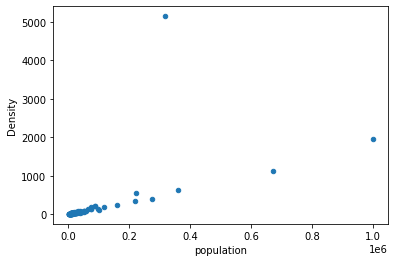

In [116]:
results=merge_corona_census(corona, locations, census)
results.plot.scatter(x='population', y='Density')

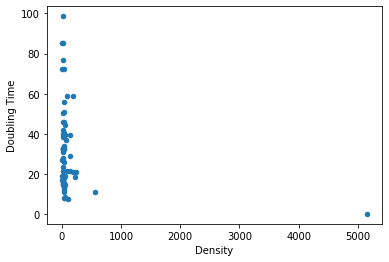

In [117]:
results.plot.scatter(x='Density', y='Doubling Time')

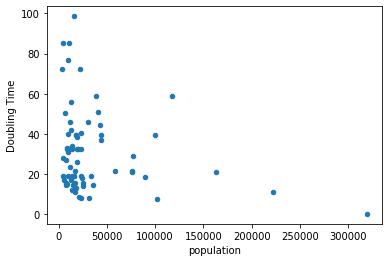

In [118]:
results.plot.scatter(x='population', y='Doubling Time')

In [120]:
import seaborn as sns

[None]

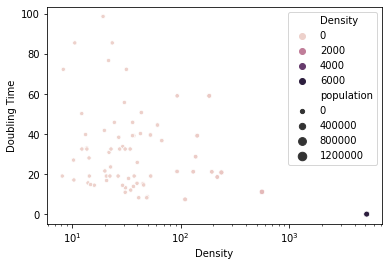

In [121]:
ax = sns.scatterplot(x="Density", y="Doubling Time",
                     hue="Density", size="population",
                     data=results)

ax.set(xscale='log')